In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import jax
# jax.config.update("jax_enable_x64", True)

import jax.numpy as jnp
import jax.random as jr
from jax.tree_util import Partial

import hugegp as gp
import hugegp_cuda as gp_cuda
import jaxkd as jk

import numpy as np
import matplotlib.pyplot as plt
import cmasher as cmr
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import time
from tqdm import tqdm

rng = jr.key(137)

In [3]:
rng, k1 = jr.split(rng)
points = jr.normal(k1, (10_000, 2))
p, s, i = gp.build_tree(points, cuda=True)
neighbors = gp.query_preceding_neighbors(p, s, n0=100, k=8, cuda=True)
depths = gp.compute_depths_parallel(neighbors, n0=100, cuda=True)

In [4]:
gp.order_by_depth(p, i, neighbors, depths, cuda=False)

(Array([[ 2.0550156e-03, -1.4791584e+00],
        [-1.8787655e-01,  1.0548082e-02],
        [ 1.0547643e+00, -9.2259180e-03],
        ...,
        [-2.4404142e+00, -4.8379722e-01],
        [-1.1562353e+00, -1.0240307e+00],
        [-3.0796322e-01, -6.6058010e-01]], dtype=float32),
 Array([3050, 6640, 5455, ..., 9375, 3712, 6151], dtype=int32),
 Array([[  36,    4,   20, ...,   96,   48,   84],
        [  37,    1,   18, ...,   53,   69,   66],
        [  22,   86,   38, ...,   70,   98,   50],
        ...,
        [9465, 8369, 1345, ..., 8378,  800, 8990],
        [6102, 8380, 1896, ..., 9462, 9975, 7655],
        [9912, 3529, 9978, ..., 5514, 2905, 8999]], dtype=int32),
 Array([-1, -1, -1, ..., 40, 40, 40], dtype=int32))

In [5]:
gp.order_by_depth(p, i, neighbors, depths, cuda=True)

(Array([[ 0.00205502, -1.4791584 ],
        [-0.18787655,  0.01054808],
        [ 1.0547643 , -0.00922592],
        ...,
        [ 0.20127584,  0.8920082 ],
        [-0.49337518, -0.86652654],
        [-0.4279263 , -0.5079613 ]], dtype=float32),
 Array([3050, 6640, 5455, ..., 9304, 4911, 5884], dtype=int32),
 Array([[  59,   71,   18, ...,   37,   96,   48],
        [   4,   20,   76, ...,   14,   24,   53],
        [  38,   36,   73, ...,   88,   79,   90],
        ...,
        [8361, 6866, 7572, ..., 7995,  787, 3927],
        [7063, 2877, 8174, ..., 4295, 3643, 6329],
        [3897, 6188, 1927, ..., 8338, 1373,  317]], dtype=int32),
 Array([-1, -1, -1, ..., 40, 40, 40], dtype=int32))

In [6]:
tree = gp.build_tree(points, cuda=True)
tree[2]

Array([3050, 6640, 5455, ..., 8244, 9720, 1829], dtype=int32)

In [7]:
tree = gp.build_tree(points, cuda=False)
tree[2]

Array([3050, 6640, 5455, ..., 8244, 9720, 1829], dtype=int32)

In [12]:
rng, k1 = jr.split(rng)
keys = jr.uniform(k1, (50_000_000,))
keys

Array([0.38371575, 0.9104594 , 0.00746751, ..., 0.23924792, 0.84285426,
       0.06569266], dtype=float32)

In [13]:
gp_cuda.sort(keys)

Array([0.       , 0.       , 0.       , ..., 0.9999999, 0.9999999,
       0.9999999], dtype=float32)

In [14]:
jnp.sort(keys)

Array([0.       , 0.       , 0.       , ..., 0.9999999, 0.9999999,
       0.9999999], dtype=float32)

In [3]:
rng, k1 = jr.split(rng)
points = jr.normal(k1, (100_000, 2))
graph = gp.build_graph(points, n0=100, k=5, cuda=True)
gp.check_graph(graph)
covariance = (gp.make_cov_bins(r_min=1e-3, r_max=10, n_bins=1000), gp.MaternCovariance(p=0))

In [4]:
points, split_dims, indices = gp.build_tree(points)
neighbors = gp.query_preceding_neighbors(points, split_dims, n0=100, k=10, cuda=True)

In [5]:
depths1 = gp.compute_depths_parallel(neighbors, n0=100)
depths1.block_until_ready()

Array([ 0,  0,  0, ..., 65, 66, 68], dtype=int32)

In [6]:
depths1 = gp.compute_depths_parallel(neighbors, n0=100, cuda=True)
depths1.block_until_ready()

Array([ 0,  0,  0, ..., 65, 66, 68], dtype=int32)

In [7]:
depths2 = gp.compute_depths_serial(neighbors, n0=100)
depths2.block_until_ready()

Array([ 0,  0,  0, ..., 65, 66, 68], dtype=int32)

In [9]:
depths2 = gp.compute_depths_serial(neighbors, n0=100, cuda=True)
depths2.block_until_ready()

ValueError: too many values to unpack (expected 2)

In [10]:
points_reordered, split_dims, indices = gp.build_tree(points, cuda=True)
neighbors = gp.query_preceding_neighbors(
    points_reordered, split_dims, n0=1000, k=5, cuda=True
)
depths = gp_cuda.compute_depths(neighbors, n0=1000, n_steps=100)
depths

Array([ 0,  0,  0, ..., 20, 22, 22], dtype=int32)

In [11]:
points_final, indices_final, neighbors_final, depths_final = gp.order_by_depth(
    points_reordered, indices, neighbors, depths, cuda=True
)
depths_final

Array([ 0,  0,  0, ..., 32, 33, 33], dtype=int32)

In [14]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, (len(points),))
values = gp.generate(graph, covariance, xi, cuda=True)
values

Array([-0.6829882 , -0.9026187 ,  0.03899484, ..., -0.4875435 ,
       -1.2495725 ,  0.6623627 ], dtype=float32)

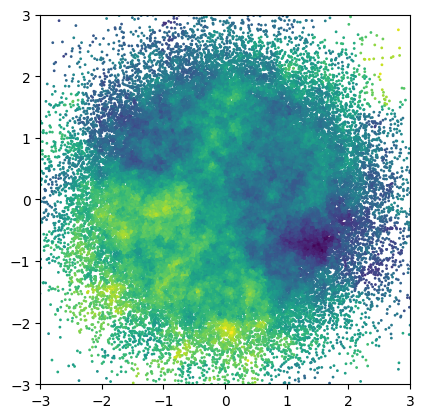

In [15]:
plt.scatter(*points.T, c=values, s=1)
plt.gca().set(aspect="equal", xlim=(-3, 3), ylim=(-3, 3))
plt.show()

In [ ]:
rng, k1 = jr.split(rng)
original_points = jr.uniform(k1, (1000000, 3))
points, split_dims, indices, tags, ranges = gp_cuda.build_tree(original_points)
jax_points, jax_split_dims, jax_indices = gp.build_tree(original_points)

neighbors = gp.tree.query_neighbors(points, split_dims, jnp.arange(len(points)), len(points)*jnp.ones(len(points)), k=10)
jax_neighbors = gp.tree.query_neighbors(jax_points, jax_split_dims, jnp.arange(len(jax_points)), len(points)*jnp.ones(len(jax_points)), k=10)

jnp.all(indices == jax_indices)

In [ ]:
gp_cuda.build_tree(original_points)

(Array([[0.1946603 , 0.7414403 , 0.50009763],
        [0.5001869 , 0.91622365, 0.4246986 ],
        [0.5001427 , 0.94144356, 0.58798957],
        ...,
        [0.8307346 , 0.8035704 , 0.28475475],
        [0.8500223 , 0.7746314 , 0.77249515],
        [0.20496309, 0.05681586, 0.01527488]], dtype=float32),
 Array([2, 0, 0, ..., 0, 0, 0], dtype=int32),
 Array([  3501, 366650, 868808, ..., 169366,  56269, 406870], dtype=int32),
 Array([     0,      1,      2, ..., 999997, 999998, 999999], dtype=int32),
 Array([0.99999964, 0.99999917, 0.9999924 , ..., 0.        , 0.        ,
        0.        ], dtype=float32))

In [ ]:
gp.build_tree(original_points)

(Array([[0.7597407 , 0.33237875, 0.50009763],
        [0.50018287, 0.6626471 , 0.17019343],
        [0.5001427 , 0.94144356, 0.58798957],
        ...,
        [0.8307346 , 0.8035704 , 0.28475475],
        [0.8500223 , 0.7746314 , 0.77249515],
        [0.20496309, 0.05681586, 0.01527488]], dtype=float32),
 Array([2, 0, 0, ..., 0, 0, 0], dtype=int32),
 Array([429063,  66007, 868808, ..., 169366,  56269, 406870], dtype=int32))

In [ ]:
dist = jnp.linalg.norm(points[neighbors] - points[:,None], axis=-1)[jnp.argsort(indices)]
jax_dist = jnp.linalg.norm(jax_points[jax_neighbors] - jax_points[:,None], axis=-1)[jnp.argsort(jax_indices)]
wrong = jnp.flatnonzero(jnp.max(dist != jax_dist, axis=-1))
len(wrong)

0

In [ ]:
def bitonic_sort(keys, n):
    u = 1
    while u < n:
        print(f"up: {u}")
        sort_up(keys, u, n)
        
        print(keys)
        d = u // 2
        while d > 0:
            print(f"down: {d}")
            sort_down(keys, d, n)
            
            print(keys)
            d //= 2
        u += u
        

def sort_up(keys, stride, n):
    for i in range(0, n):
        s = i & -stride
        l = i + s
        r = l ^ (2 * stride - 1)
        # print(l, r)
        if (r < n):
            k1 = keys[l]
            k2 = keys[r]
            if k1 > k2:
                keys[l] = k2
                keys[r] = k1

def sort_down(keys, stride, n):
    for i in range(0, n):
        s = i & -stride
        l = i + s
        r = l + stride
        # print(l, r)
        if (r < n):
            k1 = keys[l]
            k2 = keys[r]
            if k1 > k2:
                keys[l] = k2
                keys[r] = k1

In [29]:
keys = np.arange(10)[::-1]
print(keys)
bitonic_sort(keys, len(keys))

[9 8 7 6 5 4 3 2 1 0]
up: 1
[8 9 6 7 4 5 2 3 0 1]
up: 2
[7 6 9 8 3 2 5 4 0 1]
down: 1
[6 7 8 9 2 3 4 5 0 1]
up: 4
[5 4 3 2 9 8 7 6 0 1]
down: 2
[3 2 5 4 7 6 9 8 0 1]
down: 1
[2 3 4 5 6 7 8 9 0 1]
up: 8
[2 3 4 5 6 7 1 0 9 8]
down: 4
[2 3 1 0 6 7 4 5 9 8]
down: 2
[1 0 2 3 4 5 6 7 9 8]
down: 1
[0 1 2 3 4 5 6 7 8 9]


In [9]:
def compute_start(tag, n_above, n_remaining):
    n_level = n_above + 1
    q = n_remaining // n_level
    r = n_remaining % n_level
    i = tag - n_above
    start = jnp.where(
        i < r,
        i * (q + 1),
        r * (q + 1) + (i - r) * q
    )
    start += n_above
    return start

def compute_end(tag, n_above, n_remaining):
    n_level = n_above + 1
    q = n_remaining // n_level
    r = n_remaining % n_level
    i = tag - n_above
    end = jnp.where(
        i < r,
        (i + 1) * (q + 1),
        (r * (q + 1) + (i - r + 1) * q)
    )
    end += n_above
    return end

def update_tags(tags, n_above, n_remaining):
    n_level = n_above + 1
    start = compute_start(tags, n_above, n_remaining)
    end = compute_end(tags, n_above, n_remaining)
    midpoint = (start + end) // 2
    index = jnp.arange(n_above + n_remaining)
    tags = jnp.where(
        (index < n_above) | (index == midpoint),
        tags,
        jnp.where(
            index < midpoint,
            tags + n_level,
            tags + 2 * n_level
        )
    )
    return tags

In [ ]:
tags = jnp.zeros((26,), dtype=int)
for level in range(jnp.frexp(len(tags) + 1)[1] - 1):
    tags = update_tags(tags, (1 << level) - 1, len(tags) - ((1<<level)-1))
    # print(tags)
    tags = jnp.sort(tags)
    # print(tags)

In [ ]:
jnp.all(tags == jnp.arange(len(tags)))

Array(True, dtype=bool)

In [ ]:
rng, k1 = jr.split(rng)
points = jr.uniform(k1, (100_000_000,))
sorted = gp_cuda.primitive.sort(points)
sorted

Array([0.       , 0.       , 0.       , ..., 0.9999999, 0.9999999,
       0.9999999], dtype=float32)

In [ ]:
rng, k1 = jr.split(rng)
points = jr.uniform(k1, (100_000_000,))
jnp.sort(points)

2025-09-04 23:21:33.302839: W external/xla/xla/tsl/framework/bfc_allocator.cc:501] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.50GiB (rounded to 1615695616)requested by op 
2025-09-04 23:21:33.303011: W external/xla/xla/tsl/framework/bfc_allocator.cc:512] ************************************************************************************________________
E0904 23:21:33.303057   16027 pjrt_stream_executor_client.cc:2839] Execution of replica 0 failed: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1615695488 bytes. [tf-allocator-allocation-error='']


ValueError: RESOURCE_EXHAUSTED: Out of memory while trying to allocate 1615695488 bytes.

In [ ]:
def estimate_memory(jitted_function, *args, **kwargs):
    stats = jitted_function.lower(*args, **kwargs).compile().memory_analysis()
    total_mem = stats.temp_size_in_bytes + stats.argument_size_in_bytes + stats.output_size_in_bytes
    return total_mem / 1024**3

In [ ]:
rng, k1 = jr.split(rng)
points = jr.normal(k1, shape=(10_000_000, 2))

In [ ]:
points, split_dims, indices = gp.build_tree(points)
points[0]
estimate_memory(gp.build_tree, points)

0.5215419083833694

In [ ]:
0.52 * 100

52.0

In [ ]:
neighbors = gp.query_preceding_neighbors(points, split_dims, n0=1000, k=8, cuda=True)
neighbors[0]
estimate_memory(jax.jit(Partial(gp.query_preceding_neighbors, n0=1000, k=8, cuda=True)), points, split_dims)

0.40975213050842285

In [ ]:
depths = gp.graph.compute_depths(neighbors, n0=1000, cuda=True)
depths[0]
estimate_memory(jax.jit(Partial(gp.graph.compute_depths, n0=1000, cuda=True)), neighbors)

0.33524632453918457

In [ ]:
points, indices, neighbors, depths = gp.graph.order_by_depth(points, indices, neighbors, depths)
points[0]
estimate_memory(gp.graph.order_by_depth, points, indices, neighbors, depths)

0.931263267993927

In [ ]:
graph = gp.build_graph(points, n0=1000, k=8, cuda=True)
covariance = (gp.make_cov_bins(r_min=1e-4, r_max=10, n_bins=1000), gp.MaternCovariance(p=0))

In [ ]:
estimate_memory(gp.generate_jit, graph, covariance, jnp.zeros(len(points)), cuda=True)

0.5215222164988518

In [ ]:
values = gp.generate_jit(graph, (cov_bins, covariance), xi)
xi_back = gp.generate_inv_jit(graph, (cov_bins, covariance), values)
values_back = gp.generate_jit(graph, (cov_bins, covariance), xi_back)

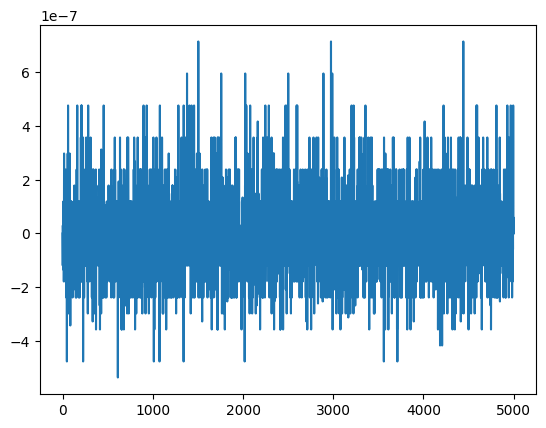

In [ ]:
plt.plot(values - values_back)

In [ ]:
cuda_values = gp.generate(graph, (cov_bins, covariance), xi, cuda=True)
cuda_values

Array([-0.84527874, -0.33612138,  0.41439384, ...,  0.11314134,
        1.2413161 , -2.211014  ], dtype=float32)

(-0.0001, 0.0001)

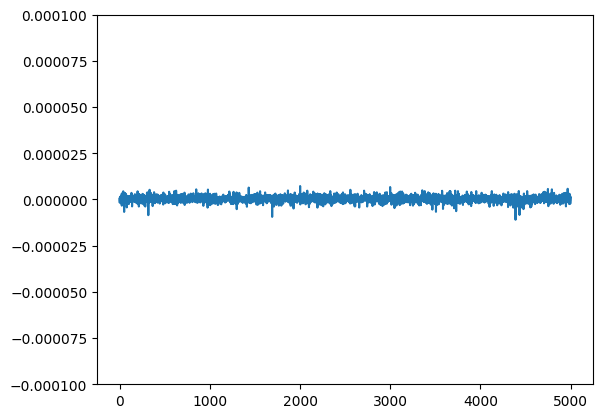

In [ ]:
plt.plot(values - cuda_values)
plt.ylim(-1e-4, 1e-4)

In [ ]:
rng, k1 = jr.split(rng)
xi = jr.normal(k1, shape=(len(points),))
values = gp.generate(graph, gp.MaternCovariance(p=0), xi)
values

Array([1.2794071 , 1.738562  , 0.7178262 , ..., 0.76837796, 1.2322326 ,
       0.5416563 ], dtype=float32)

# Inspect variance

In [ ]:
rng, key = jr.split(rng)
points = jr.normal(key, shape=(5_000, 2))
graph = gp.build_graph(points, n0=100, k=16)
covariance = gp.MaternCovariance(p=0)

In [ ]:
func = Partial(gp.generate, graph, covariance)
test_xi = jnp.zeros(len(points))
J = jax.jit(jax.jacfwd(func))(test_xi)
K = J @ J.T

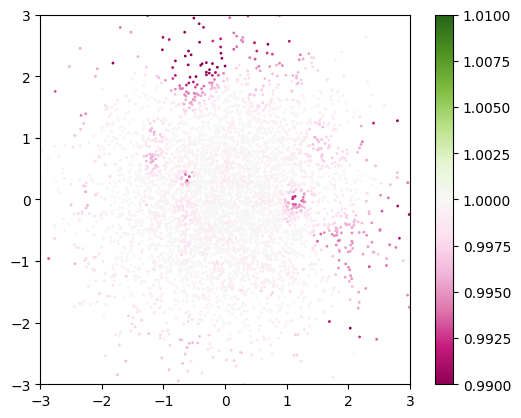

In [ ]:
sigma = jnp.sqrt(jnp.diag(K))

plt.scatter(*points.T, c=sigma, cmap='PiYG', s=1, vmin=0.99, vmax=1.01)
plt.gca().set(aspect='equal', xlim=(-3,3), ylim=(-3,3))
plt.colorbar()
plt.show()